# Fig 1: SR search mask illustration
This notebook builds a jagged ignition, evolves it for 20 minutes, and visualizes:
- initial vs evolved fire boundaries
- the search mask between boundaries
- the same mask in (s, r) coordinates plus SR fields

It also shows random (s, r) drop samples with delta = 0.0 on a high-resolution, small-domain grid.


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from matplotlib.patches import Polygon
from matplotlib.collections import LineCollection
import matplotlib.patheffects as patheffects

from fire_model.ca import FireEnv, CAFireModel, FireState
from fire_model.bo_sr import RetardantDropBayesOptSR

np.set_printoptions(precision=3, suppress=True)
plt.rcParams.update(
    {
        "figure.dpi": 160,
        "savefig.dpi": 300,
        "font.size": 10.5,
        "axes.titlesize": 11,
        "axes.labelsize": 10,
        "legend.fontsize": 9,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "axes.linewidth": 0.8,
        "lines.linewidth": 1.5,
    }
)

rng = np.random.default_rng(7)


## Helpers


In [52]:
def smooth_noise(rng, nx, ny, iters=4):
    a = rng.normal(size=(nx, ny))
    for _ in range(iters):
        a = (
            0.45 * a
            + 0.10 * np.roll(a, 1, 0) + 0.10 * np.roll(a, -1, 0)
            + 0.10 * np.roll(a, 1, 1) + 0.10 * np.roll(a, -1, 1)
            + 0.05 * np.roll(np.roll(a, 1, 0), 1, 1)
            + 0.05 * np.roll(np.roll(a, -1, 0), -1, 1)
            + 0.05 * np.roll(np.roll(a, 1, 0), -1, 1)
            + 0.05 * np.roll(np.roll(a, -1, 0), 1, 1)
        )
    return (a - a.mean()) / (a.std() + 1e-9)

def jagged_ignition_mask(nx, ny, center, radius_cells, rng, jitter=0.22, iters=4):
    x = np.arange(nx)[:, None]
    y = np.arange(ny)[None, :]
    dx = x - center[0]
    dy = y - center[1]
    dist = np.hypot(dx, dy)
    noise = smooth_noise(rng, nx, ny, iters=iters)
    thresh = radius_cells * (1.0 + jitter * noise)
    mask = dist <= thresh
    mask &= dist <= radius_cells * (1.0 + 1.5 * jitter)
    return mask

def build_initial_firestate(model, rng, center, radius_km, jitter=0.22):
    nx, ny = model.env.grid_size
    radius_cells = float(radius_km) / model.dx
    mask = jagged_ignition_mask(nx, ny, center, radius_cells, rng, jitter=jitter, iters=4)
    mask &= (model.env.fuel > 0.0)

    burning = np.zeros((1, nx, ny), dtype=bool)
    burning[0, mask] = True
    burned = np.zeros_like(burning)
    burn_remaining = np.full((1, nx, ny), float(model.env.burn_time_s0), dtype=float)
    retardant = np.zeros((1, nx, ny), dtype=float)
    return FireState(burning=burning, burned=burned, burn_remaining_s=burn_remaining, retardant=retardant, t=0)

def compute_sr_fields(bo):
    grid = bo.sr_grid
    mask = bo.search_domain_mask

    valid = np.isfinite(grid[..., 0]) & np.isfinite(grid[..., 1])
    pts = grid[valid]
    idxs = np.column_stack(np.where(valid))
    tree = cKDTree(pts)

    coords = np.column_stack(np.where(mask)).astype(float)
    dist, nn = tree.query(coords, k=1)

    s_idx = idxs[nn, 0]
    r_idx = idxs[nn, 1]

    s_field = np.full(mask.shape, np.nan)
    r_field = np.full(mask.shape, np.nan)
    s_field[coords[:, 0].astype(int), coords[:, 1].astype(int)] = s_idx / float(grid.shape[0] - 1)
    r_field[coords[:, 0].astype(int), coords[:, 1].astype(int)] = bo.sr_r_targets[r_idx]

    dist_field = np.full(mask.shape, np.nan)
    dist_field[coords[:, 0].astype(int), coords[:, 1].astype(int)] = dist

    counts = np.zeros(grid.shape[:2], dtype=int)
    np.add.at(counts, (s_idx, r_idx), 1)
    return s_field, r_field, dist_field, counts, dist

def rect_corners(x0, y0, phi, half_w, half_h):
    c = np.cos(phi)
    s = np.sin(phi)
    corners_local = np.array(
        [
            [-half_w, -half_h],
            [ half_w, -half_h],
            [ half_w,  half_h],
            [-half_w,  half_h],
        ],
        dtype=float,
    )
    rot = np.array([[c, s], [-s, c]], dtype=float)
    corners = corners_local @ rot.T
    corners[:, 0] += x0
    corners[:, 1] += y0
    return corners


## Fig 1: Jagged ignition -> evolved fire -> SR mapping


In [ ]:
# Environment for Fig 1.
nx = ny = 180
domain_km = 1.8

fuel = np.ones((nx, ny), dtype=float)
fuel *= 1.0 + 0.08 * smooth_noise(rng, nx, ny, iters=3)
fuel = np.clip(fuel, 0.6, 1.4)

value = np.ones((nx, ny), dtype=float)

wind = np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = 8.0
wind[..., 1] = -3.0

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    fuel=fuel,
    value=value,
    wind=wind,
    dt_s=1.0,
    burn_time_s0=500.0,
    retardant_half_life_s=3600.0,
    retardant_k=8.0,
    drop_w_km=0.02,
    drop_h_km=0.10,
    drop_amount=1.0,
    ros_mps=0.11,
    wind_coeff=0.04,
    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.25,
)

model = CAFireModel(env, seed=3)

center = (nx // 2 - 8, ny // 2 + 6)
init_state = build_initial_firestate(model, rng, center=center, radius_km=0.09, jitter=0.24)

bo = RetardantDropBayesOptSR(
    fire_model=model,
    init_firestate=init_state,
    n_drones=1,
    evolution_time_s=20 * 60,
    n_sims=20,
    fire_boundary_probability=0.5,
    search_grid_evolution_time_s=20 * 60,
)

bo.setup_search_grid_sr(
    K=420,
    boundary_field="affected",
    n_r=120,
    smooth_iters=240,
    omega=1.0,
)

s_field, r_field, dist_field, sr_counts, dist = compute_sr_fields(bo)

init_affected = (init_state.burning[0] | init_state.burned[0]).astype(float)
final_state = bo.final_search_firestate
final_affected = np.clip(final_state.burning[0] + final_state.burned[0], 0.0, 1.0)
extent_km = [0, domain_km, 0, domain_km]


No drone_params


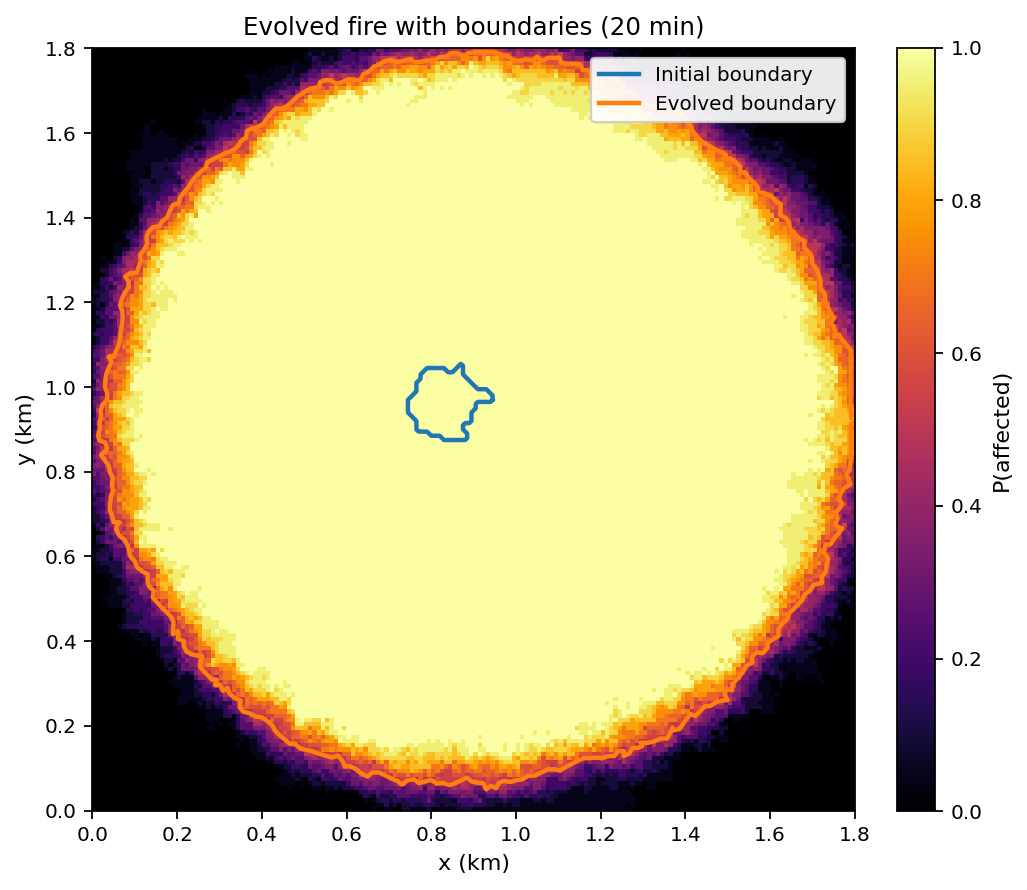

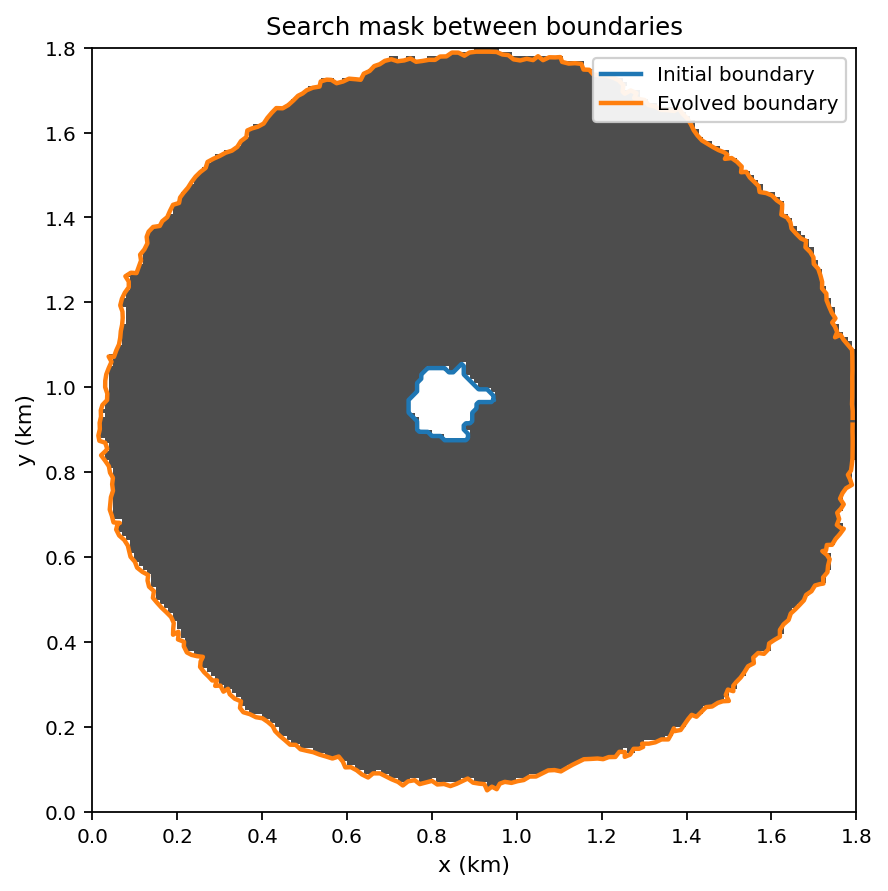

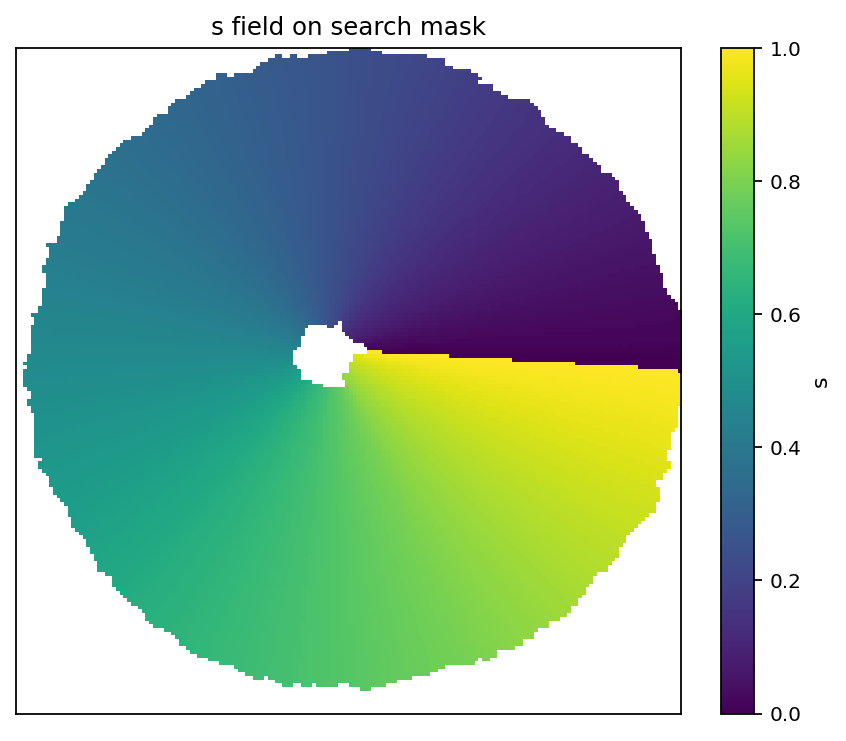

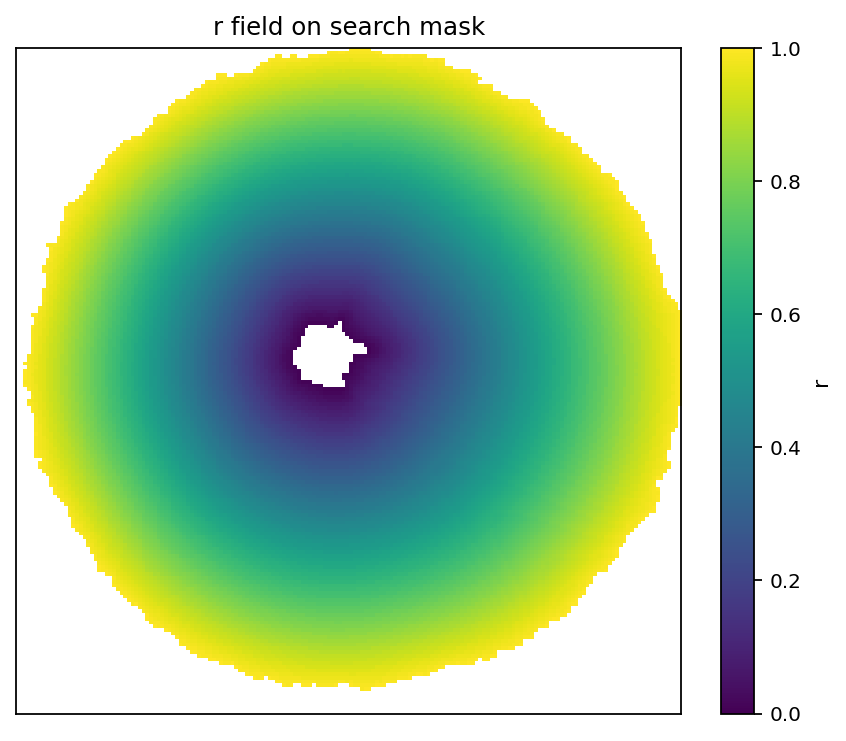

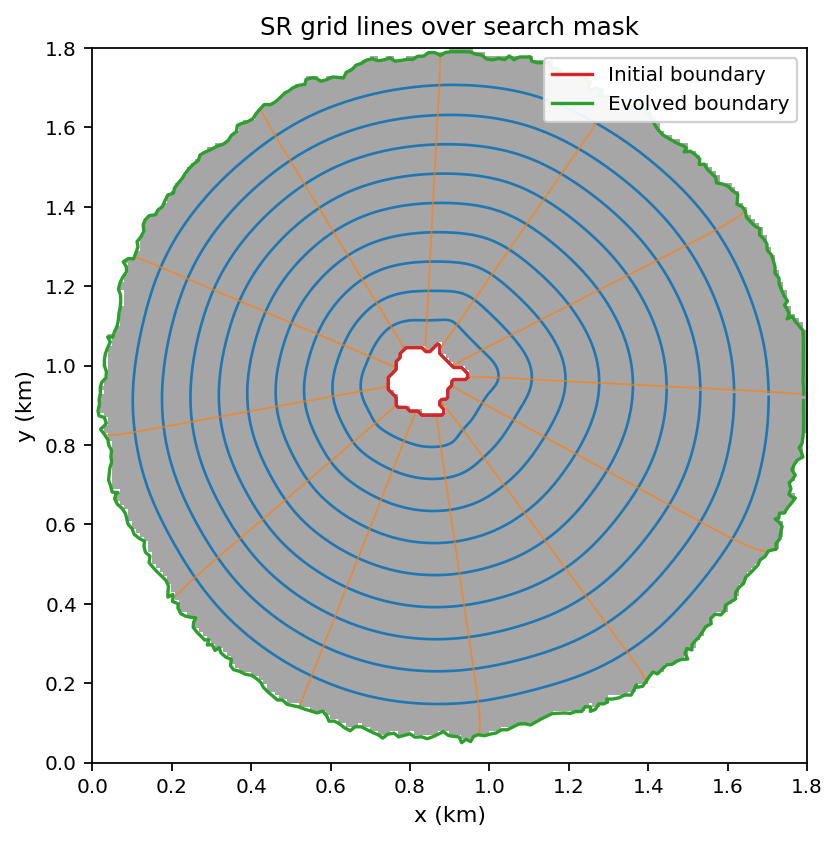

In [54]:
scale_km = env.domain_km / nx
b0_xy_km = bo.init_boundary.xy * scale_km
b1_xy_km = bo.final_boundary.xy * scale_km

# 1) Evolved fire with initial + evolved boundaries (km) and save to PDF.
fig, ax = plt.subplots(figsize=(6.8, 6.2))
im_aff = ax.imshow(
    final_affected.T,
    origin="lower",
    vmin=0.0,
    vmax=1.0,
    cmap="inferno",
    extent=extent_km,
)
ax.plot(b0_xy_km[:, 0], b0_xy_km[:, 1], color="tab:blue", linewidth=2, label="Initial boundary")
ax.plot(b1_xy_km[:, 0], b1_xy_km[:, 1], color="tab:orange", linewidth=2, label="Evolved boundary")
ax.set_title("Evolved fire with boundaries (20 min)")
ax.set_xlabel("x (km)")
ax.set_ylabel("y (km)")
ax.set_aspect("equal")
cbar_aff = fig.colorbar(im_aff, ax=ax, fraction=0.046)
cbar_aff.set_label("P(affected)")
leg = ax.legend(loc="upper right", frameon=True, fontsize=9)
leg.get_frame().set_facecolor("white")
leg.get_frame().set_alpha(0.92)
fig.savefig("fig_evolved_fire.pdf", dpi=100, bbox_inches="tight")
plt.show()

# 2) Search mask between boundaries with legend (km).
fig, ax = plt.subplots(figsize=(6.8, 6.2))
ax.imshow(bo.search_domain_mask.T, origin="lower", cmap="Greys", alpha=0.7, extent=extent_km)
ax.plot(b0_xy_km[:, 0], b0_xy_km[:, 1], color="tab:blue", linewidth=2, label="Initial boundary")
ax.plot(b1_xy_km[:, 0], b1_xy_km[:, 1], color="tab:orange", linewidth=2, label="Evolved boundary")
ax.set_title("Search mask between boundaries")
ax.set_xlabel("x (km)")
ax.set_ylabel("y (km)")
ax.set_aspect("equal")
leg = ax.legend(loc="upper right", frameon=True, fontsize=9)
leg.get_frame().set_facecolor("white")
leg.get_frame().set_alpha(0.92)
fig.savefig("fig_search_mask.pdf", dpi=100, bbox_inches="tight")
plt.show()

# 3) s field on mask.
fig, ax = plt.subplots(figsize=(6.4, 5.4))
im_s = ax.imshow(s_field.T, origin="lower", cmap="viridis")
ax.set_title("s field on search mask")
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("equal")
cbar_s = fig.colorbar(im_s, ax=ax, fraction=0.046)
cbar_s.set_label("s")
fig.savefig("fig_s_field.pdf", dpi=100, bbox_inches="tight")
plt.show()

# 4) r field on mask.
fig, ax = plt.subplots(figsize=(6.4, 5.4))
im_r = ax.imshow(r_field.T, origin="lower", cmap="viridis")
ax.set_title("r field on search mask")
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("equal")
cbar_r = fig.colorbar(im_r, ax=ax, fraction=0.046)
cbar_r.set_label("r")
fig.savefig("fig_r_field.pdf", dpi=100, bbox_inches="tight")
plt.show()

# 5) SR grid lines over search mask (km) with save.
fig, ax = plt.subplots(figsize=(6.6, 5.8))
ax.imshow(bo.search_domain_mask.T, origin="lower", cmap="Greys", alpha=0.35, extent=extent_km)

grid = bo.sr_grid
for j in range(0, grid.shape[1], max(1, grid.shape[1] // 10)):
    curve = grid[:, j]
    ax.plot(curve[:, 0] * scale_km, curve[:, 1] * scale_km, color="tab:blue", linewidth=1.2)
for i in range(0, grid.shape[0], max(1, grid.shape[0] // 12)):
    curve = grid[i]
    ax.plot(curve[:, 0] * scale_km, curve[:, 1] * scale_km, color="tab:orange", linewidth=0.8, alpha=0.7)

ax.plot(b0_xy_km[:, 0], b0_xy_km[:, 1], color="tab:red", linewidth=1.5, label="Initial boundary")
ax.plot(b1_xy_km[:, 0], b1_xy_km[:, 1], color="tab:green", linewidth=1.5, label="Evolved boundary")
ax.set_title("SR grid lines over search mask")
ax.set_xlabel("x (km)")
ax.set_ylabel("y (km)")
ax.set_aspect("equal")
leg = ax.legend(loc="upper right", frameon=True, fontsize=9)
leg.get_frame().set_facecolor("white")
leg.get_frame().set_alpha(0.92)
fig.savefig("fig_sr_grid.pdf", dpi=100, bbox_inches="tight")
plt.show()


## Optional: SR grid overlay and diagnostics


In [55]:
# (Deprecated) SR grid overlay handled in the main figure cell above.


In [56]:
# (Deprecated) Diagnostics were removed for the publication-ready figure set.


## Random (s, r) samples with delta = 0.0 (high-resolution grid)


In [ ]:
nx2 = ny2 = 300
domain_km2 = 0.30

fuel2 = np.ones((nx2, ny2), dtype=float)
value2 = np.ones((nx2, ny2), dtype=float)

wind2 = np.zeros((nx2, ny2, 2), dtype=float)
wind2[..., 0] = 3.0
wind2[..., 1] = -1.0

env2 = FireEnv(
    grid_size=(nx2, ny2),
    domain_km=domain_km2,
    fuel=fuel2,
    value=value2,
    wind=wind2,
    dt_s=1.0,
    burn_time_s0=450.0,
    retardant_half_life_s=3600.0,
    retardant_k=8.0,
    drop_w_km=0.005,  # 5 m
    drop_h_km=0.05,   # 50 m
    drop_amount=1.0,
    ros_mps=0.11,
    wind_coeff=0.04,
    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.25,
)

model2 = CAFireModel(env2, seed=5)

center2 = (nx2 // 2 - 10, ny2 // 2 + 4)
init_state2 = build_initial_firestate(model2, rng, center=center2, radius_km=0.03, jitter=0.22)

n_samples = 5
bo2 = RetardantDropBayesOptSR(
    fire_model=model2,
    init_firestate=init_state2,
    n_drones=n_samples,
    evolution_time_s=10 * 60,
    n_sims=10,
    fire_boundary_probability=0.5,
    search_grid_evolution_time_s=10 * 60,
)

bo2.setup_search_grid_sr(
    K=320,
    boundary_field="affected",
    n_r=140,
    smooth_iters=220,
    omega=1.0,
)

coords = bo2.sr_valid_indices.astype(int)
n_samples = min(n_samples, coords.shape[0])
K2, R2 = bo2.sr_grid.shape[:2]

samples_rng = np.random.default_rng(2000)
sel = samples_rng.choice(coords.shape[0], size=n_samples, replace=False)

s_samples = coords[sel, 0] / float(K2 - 1)
r_samples = bo2.sr_r_targets[coords[sel, 1]]

params_xy = []
for s, r in zip(s_samples, r_samples):
    xy, phi_r = bo2._sr_lookup(s, r)
    phi_long = phi_r + 0.5 * np.pi
    phi = bo2._phi_from_long_axis_angle(phi_long)
    params_xy.append([xy[0], xy[1], phi])
params_xy = np.asarray(params_xy, dtype=float)

half_w = 0.5 * env2.drop_w_km / model2.dx
half_h = 0.5 * env2.drop_h_km / model2.dx


No drone_params


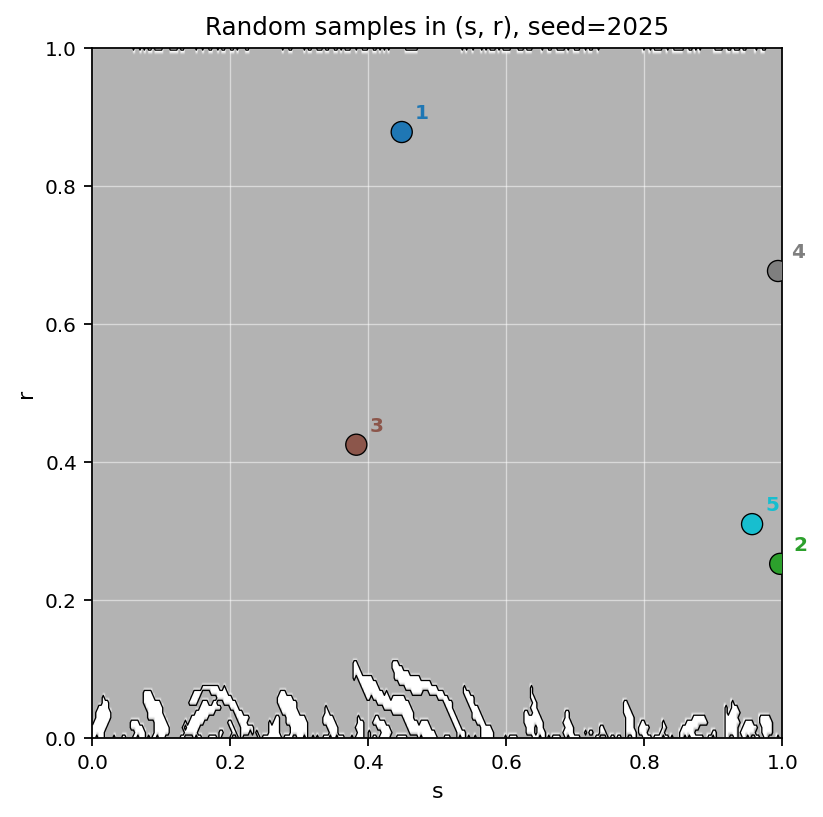

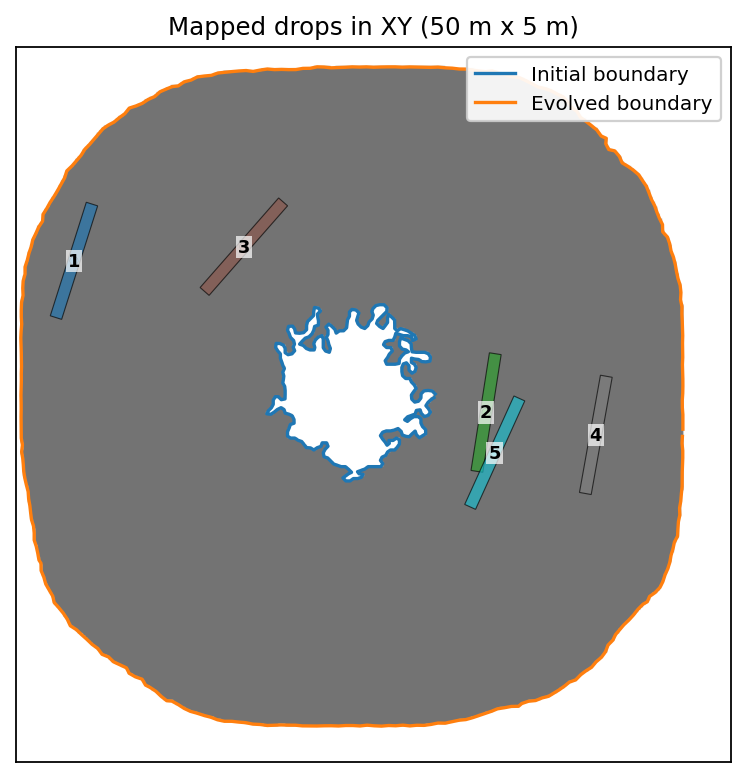

In [58]:
fig_sr, ax_sr = plt.subplots(figsize=(6.3, 5.6))
ax_sr.imshow(
    bo2.sr_valid_mask.T.astype(float),
    origin="lower",
    extent=[0, 1, 0, 1],
    aspect="equal",
    cmap="Greys",
    alpha=0.3,
)
s_grid = np.linspace(0.0, 1.0, bo2.sr_valid_mask.shape[0])
r_grid = np.linspace(0.0, 1.0, bo2.sr_valid_mask.shape[1])
S, R = np.meshgrid(s_grid, r_grid)
ax_sr.contour(S, R, bo2.sr_valid_mask.T.astype(float), levels=[0.5], colors="black", linewidths=0.6)

colors = plt.cm.tab10(np.linspace(0, 1, n_samples))
ax_sr.scatter(s_samples, r_samples, s=90, c=colors, edgecolors="black", linewidths=0.6, zorder=3)
for idx, (s, r, color) in enumerate(zip(s_samples, r_samples, colors), start=1):
    ax_sr.annotate(str(idx), (s, r), xytext=(6, 6), textcoords="offset points", color=color, fontsize=9, weight="bold")

ax_sr.set_title("Random samples in (s, r), seed=2025")
ax_sr.set_xlabel("s")
ax_sr.set_ylabel("r")
ax_sr.set_xlim(0, 1)
ax_sr.set_ylim(0, 1)
ax_sr.grid(True, color="white", linewidth=0.6, alpha=0.5)
fig_sr.savefig("fig_samples_sr.pdf", dpi=100, bbox_inches="tight")
plt.show()

fig_xy, ax_xy = plt.subplots(figsize=(6.8, 5.8))
ax_xy.imshow(bo2.search_domain_mask.T, origin="lower", cmap="Greys", alpha=0.55)
ax_xy.plot(bo2.init_boundary.xy[:, 0], bo2.init_boundary.xy[:, 1], color="tab:blue", linewidth=1.5, label="Initial boundary")
ax_xy.plot(bo2.final_boundary.xy[:, 0], bo2.final_boundary.xy[:, 1], color="tab:orange", linewidth=1.5, label="Evolved boundary")

for idx, ((x0, y0, phi), color) in enumerate(zip(params_xy, colors), start=1):
    corners = rect_corners(x0, y0, phi, half_w, half_h)
    poly = Polygon(corners, closed=True, facecolor=color, edgecolor="black", linewidth=0.5, alpha=0.65)
    ax_xy.add_patch(poly)
    ax_xy.text(
        x0,
        y0,
        str(idx),
        ha="center",
        va="center",
        fontsize=8,
        weight="bold",
        color="black",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1.0),
    )

ax_xy.scatter(params_xy[:, 0], params_xy[:, 1], c=colors, s=14, edgecolors="black", linewidths=0.2)
ax_xy.set_title("Mapped drops in XY (50 m x 5 m)")
ax_xy.set_xticks([])
ax_xy.set_yticks([])
ax_xy.set_aspect("equal")
leg = ax_xy.legend(loc="upper right", frameon=True, fontsize=9)
leg.get_frame().set_facecolor("white")
leg.get_frame().set_alpha(0.92)
fig_xy.savefig("fig_samples_xy.pdf", dpi=100, bbox_inches="tight")
plt.show()
